# Example : Measurement campaign

This example represent a sensor measurement campaign.

It shows that :
- data can simply be represented in multidimensional format and used in Xarray
- the multidimensional JSON format is the most compact of the usual formats (tabular JSON, csv and even parquet),

## description of the example

Sensors are installed in five french cities (lille, toulouse, marseille, strasbourg, brest) and measure air quality during ten days.
The measurement is the hourly mean of pollutants concentration (PM10, PM2.5, NO2, O3, CO).

The result of the acquisition is a table where fields are:

- camp : description of the campaign
- date : date of the measurement
- hour : hour of the measurement
- city : location of the sensor
- coord : coordinate of the sensor
- prop : measured property
- unit : unit of the measurement
- value : value of the measurement

## data acquisition

This section is a simulation of the data acquisition by sensors.
The result of the campaign is a pandas DataFrame.

In [1]:
import os
from random import random

columns = ['camp', 'date', 'hour', 'city', 'coord', 'prop', 'unit', 'value']

camp = 'air quality sensor measurement'
dates = ['2024/05/24', '2024/05/25', '2024/05/26', '2024/05/27', '2024/05/28', 
         '2024/05/29', '2024/05/30', '2024/05/31', '2024/06/01', '2024/06/02']
cities = ['lille', 'toulouse', 'marseille', 'strasbourg', 'brest']
coordinates = ['[3.06, 50.63]', '[1.44, 43.6]', '[5.37, 43.3]', '[7.75, 48.57]', '[4.49, 48.39]']
properties = ['PM10', 'PM2.5', 'NO2', 'O3', 'CO']
units = ['µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'mg/m3']
hours = list(range(24))

def data_acquisition(n_dates):
    '''return a list of records for a set of dates defined by the n_dates parameter'''
    return [(camp, date, hour, city, coord, prop, unit, round(random()*10, 2))
             for city, coord in zip(cities, coordinates)
                 for date in dates[:n_dates]
                     for hour in hours
                         for prop, unit in zip(properties, units) ]

In [2]:
import pandas as pd

meas_df_10 = pd.DataFrame(data_acquisition(10), columns=columns).sample(frac=1).reset_index(drop=True)
meas_df_10

,camp,date,hour,city,coord,prop,unit,value
0,air quality sensor measurement,2024/06/02,3,toulouse,"[1.44, 43.6]",PM10,µg/m3,6.41
1,air quality sensor measurement,2024/06/01,15,lille,"[3.06, 50.63]",NO2,µg/m3,0.35
2,air quality sensor measurement,2024/05/30,11,marseille,"[5.37, 43.3]",O3,µg/m3,9.48
3,air quality sensor measurement,2024/05/24,15,strasbourg,"[7.75, 48.57]",O3,µg/m3,2.70
4,air quality sensor measurement,2024/05/27,8,strasbourg,"[7.75, 48.57]",O3,µg/m3,4.49
...,...,...,...,...,...,...,...,...
5995,air quality sensor measurement,2024/05/27,11,marseille,"[5.37, 43.3]",CO,mg/m3,6.74
5996,air quality sensor measurement,2024/05/31,16,brest,"[4.49, 48.39]",PM2.5,µg/m3,4.18
5997,air quality sensor measurement,2024/05/30,4,strasbourg,"[7.75, 48.57]",NO2,µg/m3,3.44
5998,air quality sensor measurement,2024/05/31,18,lille,"[3.06, 50.63]",CO,mg/m3,8.94


## Multidimensional representation

In [3]:
import xarray as xr
import ntv_pandas

meas_xr_10 = meas_df_10.npd.to_xarray()
meas_xr_10

<xarray.Dataset> Size: 49kB
Dimensions:  (date: 10, hour: 24, city: 5, prop: 5)
Coordinates:
  * city     (city) <U10 200B 'brest' 'lille' ... 'strasbourg' 'toulouse'
  * date     (date) <U10 400B '2024/05/24' '2024/05/25' ... '2024/06/02'
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * prop     (prop) <U5 100B 'CO' 'NO2' 'O3' 'PM10' 'PM2.5'
    coord    (city) <U13 260B '[4.49, 48.39]' '[3.06, 50.63]' ... '[1.44, 43.6]'
    unit     (prop) <U5 100B 'mg/m3' 'µg/m3' 'µg/m3' 'µg/m3' 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    (date, hour, city, prop) float64 48kB 0.96 9.98 9.92 ... 5.15 0.63

In [4]:
meas_xr_10.sel(city='lille', prop='NO2', hour=0, date='2024/05/24').values

<bound method Mapping.values of <xarray.Dataset> Size: 308B
Dimensions:  ()
Coordinates:
    city     <U10 40B 'lille'
    date     <U10 40B '2024/05/24'
    hour     int64 8B 0
    prop     <U5 20B 'NO2'
    coord    <U13 52B '[3.06, 50.63]'
    unit     <U5 20B 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    float64 8B 4.56>

## data size

The multidimensional JSON size is lower than tabular JSON size, csv size and parquet size

In [5]:
import ntv_numpy

notype = [True]*len(meas_df_10.columns)
meas_js_10 = meas_xr_10.nxr.to_json(notype=notype, header=False, encoded=True)
meas_df_10.to_csv('meas_10.csv')
# meas_parquet: https://dataconverter.io/convert/csv-to-parquet/download (UNCOMPRESSED, HALF_UP)

size_10 = {'pd.to_json(values)': len(meas_df_10.to_json(orient='values')),
           'pd.to_csv': len(meas_df_10.to_csv()),
           'pd.to_parquet': os.path.getsize('meas_10.parquet'),
           'nxr.to_json': len(meas_js_10)}

meas_df_1 = pd.DataFrame(data_acquisition(1), columns=columns).sample(frac=1).reset_index(drop=True)
meas_js_1 = meas_df_1.npd.to_xarray().nxr.to_json(notype=notype, header=False, encoded=True)

size_1  = {'pd.to_json(values)': len(meas_df_1.to_json(orient='values')),
           'pd.to_csv': len(meas_df_1.to_csv()),
           'pd.to_parquet': os.path.getsize('meas_1.parquet'),
           'nxr.to_json': len(meas_js_1)}

size_1

{'pd.to_json(values)': 61615,
 'pd.to_csv': 53148,
 'pd.to_parquet': 11251,
 'nxr.to_json': 4091}

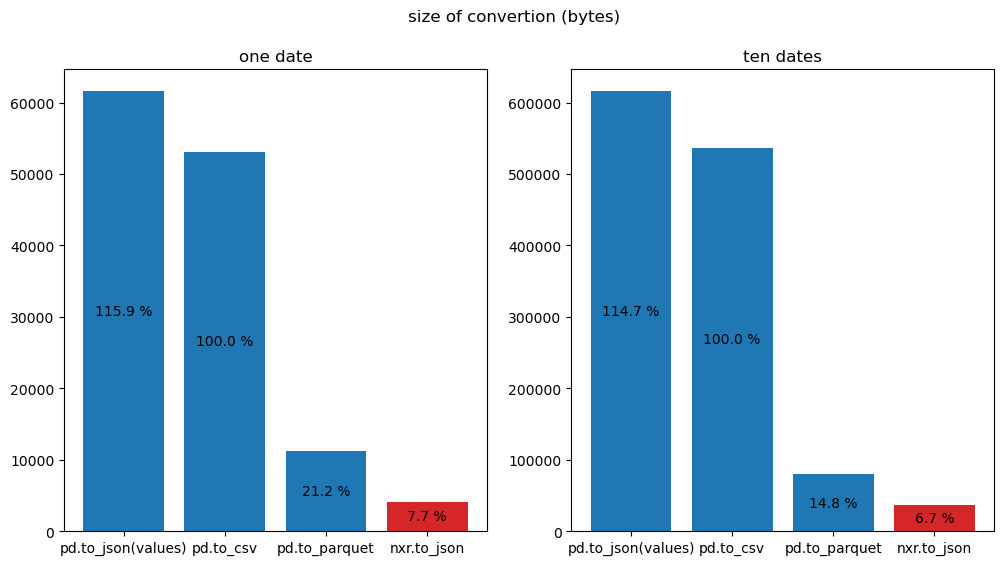

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('size of convertion (bytes)')
bar_colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:red']
percent_1 = [str(round(val / list(size_1.values())[1] * 100, 1)) + ' %' for val in size_1.values()]
percent_10 = [str(round(val / list(size_10.values())[1] * 100, 1)) + ' %' for val in size_10.values()]
plt_1 = axs[0].bar(size_1.keys(), size_1.values(), color=bar_colors)
plt_10 = axs[1].bar(size_10.keys(), size_10.values(), color=bar_colors)
axs[0].set_title('one date')
axs[0].bar_label(plt_1, percent_1, label_type='center')
axs[1].set_title('ten dates')
axs[1].bar_label(plt_10, percent_10, label_type='center')

plt.show()